## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [91]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('Homework_data.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

<AxesSubplot:xlabel='price', ylabel='Count'>

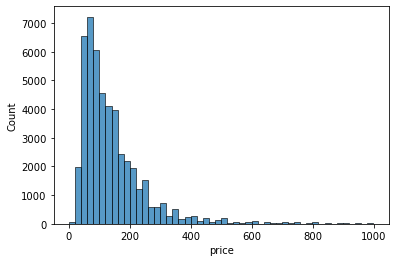

In [8]:
# plot price
sns.histplot(df.price[df.price < 1000], bins=50)

In [11]:
# Apply log transform to price
df['price_logs'] = np.log1p(df.price)

In [20]:
# Split dataset (60/20/20)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.price_logs.values
y_val = df_val.price_logs.values
y_test = df_test.price_logs.values

df_train = df_train.drop(['price', 'price_logs'], axis=1)
df_val = df_val.drop(['price', 'price_logs'], axis=1)
df_test = df_test.drop(['price', 'price_logs'], axis=1)

Now, use `DictVectorizer` to turn train and validation into matrices:

In [38]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [27]:
model = DecisionTreeRegressor(max_depth=1)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [29]:
print(export_text(model, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type` ---> answer
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [42]:
# Train model
rf_model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)

# RMSE
rmse = mean_squared_error(y_val, y_pred)
round(rmse, 3)

0.213

What's the RMSE of this model on validation?

* 0.059
* 0.259 --> answer
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [50]:
n_list = np.arange(10, 201, 10)
rmse_list = []

for n in n_list:
    rf_model = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred)
    rmse_list.append(rmse)

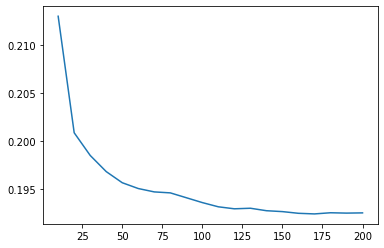

In [51]:
plt.plot(n_list, rmse_list)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120 ---> answer

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [52]:
depth = [10, 15, 20, 25]
n_list = np.arange(10, 201, 10)
score = []

for d in depth:
    for n in n_list:
        rf_model = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf_model.fit(X_train, y_train)

        y_pred = rf_model.predict(X_val)

        rmse = mean_squared_error(y_val, y_pred)
        score.append((d, n, rmse))

<AxesSubplot:xlabel='max_depth', ylabel='n_estimator'>

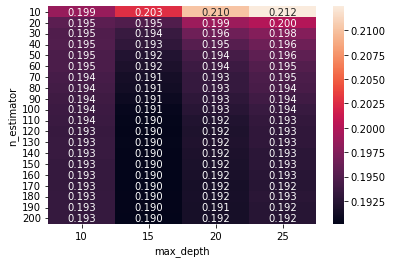

In [53]:
columns = ['max_depth', 'n_estimator', 'RMSE']
df_scores = pd.DataFrame(score, columns=columns)

df_scores_pivot = df_scores.pivot(index='n_estimator', columns='max_depth', values='RMSE')
df_scores_pivot.round(3)
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

What's the best `max_depth`:

* 10
* 15 ---> answer
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model? ---> same

In [56]:
depth = [10, 15, 20, 25]
n_list = np.arange(10, 201, 10)
score = []

for d in depth:
    for n in n_list:
        rf_model = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=22, n_jobs=-1)
        rf_model.fit(X_train, y_train)

        y_pred = rf_model.predict(X_val)

        rmse = mean_squared_error(y_val, y_pred)
        score.append((d, n, rmse))

<AxesSubplot:xlabel='max_depth', ylabel='n_estimator'>

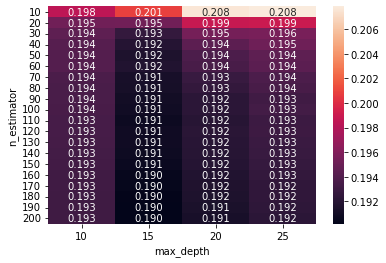

In [57]:
columns = ['max_depth', 'n_estimator', 'RMSE']
df_scores = pd.DataFrame(score, columns=columns)

df_scores_pivot = df_scores.pivot(index='n_estimator', columns='max_depth', values='RMSE')
df_scores_pivot.round(3)
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [58]:
rf_model = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [80]:
importances = rf_model.feature_importances_
importances_round = [round(im, 4) for im in importances]

In [85]:
dict(zip(dv.get_feature_names(), importances_round))

{'availability_365': 0.0763,
 'calculated_host_listings_count': 0.0301,
 'latitude': 0.1528,
 'longitude': 0.1541,
 'minimum_nights': 0.0533,
 'neighbourhood_group=Bronx': 0.0003,
 'neighbourhood_group=Brooklyn': 0.001,
 'neighbourhood_group=Manhattan': 0.034,
 'neighbourhood_group=Queens': 0.0012,
 'neighbourhood_group=Staten Island': 0.0001,
 'number_of_reviews': 0.0416,
 'reviews_per_month': 0.0544,
 'room_type=Entire home/apt': 0.3919,
 'room_type=Private room': 0.004,
 'room_type=Shared room': 0.005}

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`   ---> answer	
* `longitude` 
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Then change `eta` first to `0.1` and then to `0.01`

In [125]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [126]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [127]:
def parse_xgb_output():
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [143]:
%%capture output

scores = {}

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)
scores['eta=0.3'] = parse_xgb_output()

In [144]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)
scores['eta=0.1'] = parse_xgb_output()

In [145]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)
scores['eta=0.01'] = parse_xgb_output()

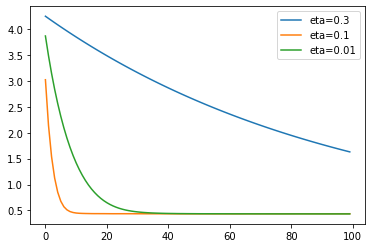

In [146]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)
    plt.legend()

What's the best eta?

* 0.3
* 0.1
* 0.01 --> answer

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

